Adesh Maharaj 20019971

## English Keyboard Layout Optimization/Generation (GA + Carpalx-inspired fitness + LLM logging)

**Goal:**

Evolve an ergonomic 45-key English base layer that minimizes strain and maximizes efficiency. The layout preserves the fixed number sequence 1234567890 in order; the remaining 35 characters (-= + letters + punctuation ,./;'[]) are optimized over the top, home, and bottom rows.

**Why:**

Standard layouts (e.g., QWERTY) place frequent letters on weaker fingers and distant rows. We use bigram statistics and an ergonomic cost model to reward home-row usage, hand alternation, and comfortable finger rolls, while penalizing awkward reaches, same-finger repetitions, and pinky overload.

---

**Introduction**

This notebook implements a Genetic Algorithm (GA) to generate and optimize ergonomic keyboard layouts for English using a Carpalx-inspired fitness function.

The work is adapted from and inspired by the MKLOGA project (https://github.com/xsznix/mkloga), which explored the use of genetic algorithms for layout generation.
The codebase has been substantially modified to:

- Apply a simplified Carpalx model with penalties for high-effort positions and poor finger alternation.
- Ensure reproducibility via fixed seeds and consistent evaluation methods.
- Add visualizations (heatmaps, key usage charts) for ergonomic assessment.
- Act as a benchmark to research mulilingual use


---

**Data**


Corpus: English text from data/TED2013 v1.1.txt (lower-cased, filtered by the MKLOGA project to the allowed character set).

Features:

- Bigram frequencies for all adjacent character pairs used by the fitness function.
- Character frequencies derived from bigrams for row/finger weighting.

# IMPORTS

Import libraries and configure the environment. Create visualizations with matplotlib.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re
from collections import Counter
from collections import defaultdict
import math
import numpy as np
from metrics_collector import MetricsCollector
from characters_placement import CharactersPlacement
from button import Button

# Keyboard setup

Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
FIXED_CHARACTERS = list('1234567890')
MUTABLE_CHARACTERS = list('-=' + "qwertyuiop[]asdfghjkl;'" + 'zxcvbnm,./')
CHARACTER_SET = FIXED_CHARACTERS + MUTABLE_CHARACTERS
assert len(CHARACTER_SET) == 45
valid_chars = set(CHARACTER_SET)
NUMBER_ROW = [(i, -1) for i in range(12)]
TOP_ROW = [(i, 0) for i in range(12)]
HOME_ROW = [(i + 0.5, 1) for i in range(11)]
BOTTOM_ROW = [(i + 1, 2) for i in range(10)]
KEYBOARD_POSITIONS = NUMBER_ROW + TOP_ROW + HOME_ROW + BOTTOM_ROW
assert len(KEYBOARD_POSITIONS) == len(CHARACTER_SET), 'Mismatch in number of keys vs characters!'
buttons = []
for idx, (x, y) in enumerate(KEYBOARD_POSITIONS):
    buttons.append(Button(id=idx, location={'x': x, 'y': y}, size={'width': 1.0, 'height': 1.0}))
QWERTY_CHARS = FIXED_CHARACTERS + list('-=' + "qwertyuiop[]asdfghjkl;'" + 'zxcvbnm,./')
assert len(QWERTY_CHARS) == len(buttons)
qwerty_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(QWERTY_CHARS)])
print('QWERTY layout loaded into CharactersPlacement.')
DVORAK_CHARS = FIXED_CHARACTERS + list('[]' + "',.pyfgcrl/=" + 'aoeuidhtns-' + ';qjkxbmwvz')
assert len(DVORAK_CHARS) == len(buttons)
dvorak_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(DVORAK_CHARS)])
print('DVORAK layout loaded.')
COLEMAK_CHARS = FIXED_CHARACTERS + list('-=' + "qwfpgjluy;[]arstdhneio'" + 'zxcvbkm,./')
assert len(COLEMAK_CHARS) == len(buttons)
colemak_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(COLEMAK_CHARS)])
print('COLEMAK layout loaded.')
MKLOGA_CHARS = FIXED_CHARACTERS + list('=,' + '.blumpcyqj[;' + "rioahntesdk-'vxzfwg]/")
assert len(MKLOGA_CHARS) == len(buttons)
mkloga_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(MKLOGA_CHARS)])
print('MKLOGA layout loaded.')

QWERTY layout loaded into CharactersPlacement.
DVORAK layout loaded.
COLEMAK layout loaded.
MKLOGA layout loaded.


Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
for name, layout in [('QWERTY', qwerty_layout), ('DVORAK', dvorak_layout), ('COLEMAK', colemak_layout)]:
    print(f'\n{name} layout character positions:')
    for ch in ['e', 't', 'a', 'n', 'i', '.', "'"]:
        try:
            btn_id = next((c.button_id for c in layout.characters_set if c.character == ch))
            btn = buttons[btn_id]
            print(f'  {ch} -> (x={btn.location.x}, y={btn.location.y})')
        except StopIteration:
            print(f'  {ch} not found in {name} layout!')


QWERTY layout character positions:
  e -> (x=2, y=0)
  t -> (x=4, y=0)
  a -> (x=0.5, y=1)
  n -> (x=6, y=2)
  i -> (x=7, y=0)
  . -> (x=9, y=2)
  ' -> (x=10.5, y=1)

DVORAK layout character positions:
  e -> (x=2.5, y=1)
  t -> (x=7.5, y=1)
  a -> (x=0.5, y=1)
  n -> (x=8.5, y=1)
  i -> (x=4.5, y=1)
  . -> (x=2, y=0)
  ' -> (x=0, y=0)

COLEMAK layout character positions:
  e -> (x=7.5, y=1)
  t -> (x=3.5, y=1)
  a -> (x=0.5, y=1)
  n -> (x=6.5, y=1)
  i -> (x=8.5, y=1)
  . -> (x=9, y=2)
  ' -> (x=10.5, y=1)


Visualize a keyboard layout using matplotlib

C:\Users\adesh\AppData\Local\Temp\ipykernel_47508\1321437333.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor="black")


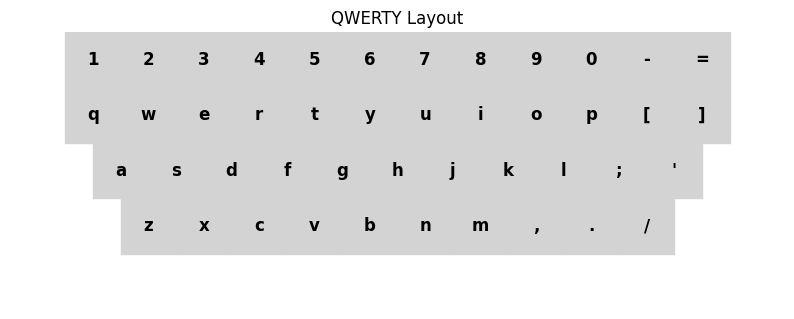

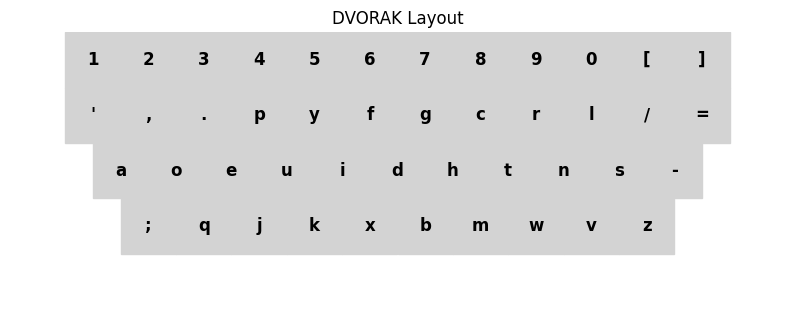

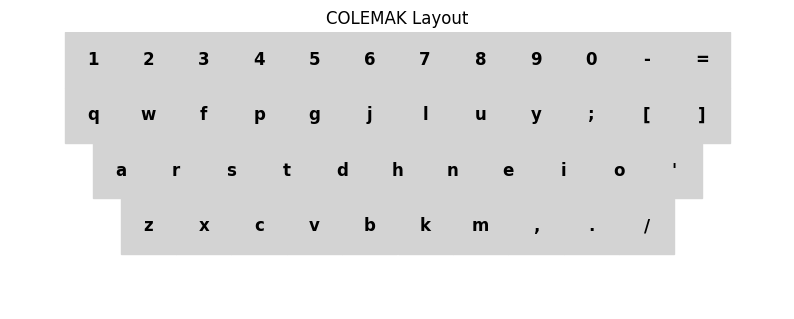

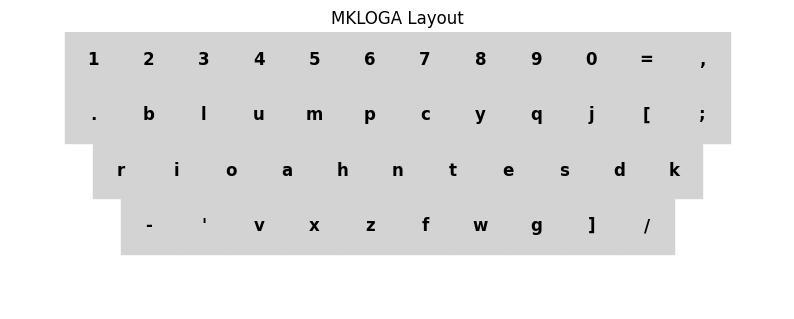

In [ ]:
def visualize_keyboard(layout, buttons, title='Keyboard Layout'):
    '''"""
    Visualize a keyboard layout using matplotlib.

    This function generates a 2D plot of the given keyboard layout by drawing
    rectangular button areas and labeling them with their assigned characters.
    It is useful for inspecting and comparing generated or predefined keyboard layouts.

    Parameters
    ----------
    layout : object
        A keyboard layout object that contains a `characters_set` attribute,
        where each element has at least:
            - character (str): The symbol assigned to the key.
            - button_id (int): Index mapping the character to a button in `buttons`.
    buttons : dict[int, object]
        A dictionary mapping button IDs to button objects, where each button has:
            - location.x, location.y (float): Top-left coordinates of the button.
            - size.width, size.height (float): Dimensions of the button.
    title : str, optional
        Title for the plot (default is "Keyboard Layout").

    Returns
    -------
    None
    """'''
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_aspect('equal')
    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        x, y = (btn.location.x, btn.location.y)
        w, h = (btn.size.width, btn.size.height)
        ax.add_patch(Rectangle((x, y), w, h, fill=True, color='#d3d3d3', edgecolor='black'))
        ax.text(x + w / 2, y + h / 2, char_obj.character, ha='center', va='center', fontsize=12, fontweight='bold')
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 4)
    ax.invert_yaxis()
    ax.axis('off')
    plt.title(title)
    plt.show()
visualize_keyboard(qwerty_layout, buttons, title='QWERTY Layout')
visualize_keyboard(dvorak_layout, buttons, title='DVORAK Layout')
visualize_keyboard(colemak_layout, buttons, title='COLEMAK Layout')
visualize_keyboard(mkloga_layout, buttons, title='MKLOGA Layout')

# Bigram loading

Load data and/or helper resources from files. Define helper functions: load_and_extract_bigrams_from_txt.

In [ ]:
CHARACTER_SET = list("qwertyuiop[]asdfghjkl;'" + 'zxcvbnm,./')
VALID_CHARS = set(CHARACTER_SET)

def load_and_extract_bigrams_from_txt(txt_path, valid_chars=None):
    '''"""
    Load and extract bigrams from txt.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    txt_path : Any
        See code for details.
    valid_chars : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    with open(txt_path, 'r', encoding='utf-8') as f:
        text_data = f.read().lower()
    if valid_chars:
        text_data = ''.join([c for c in text_data if c in valid_chars])
    else:
        text_data = re.sub('[^a-z]', '', text_data)
    bigrams = [text_data[i:i + 2] for i in range(len(text_data) - 1)]
    bigram_counts = Counter(bigrams)
    total = sum(bigram_counts.values())
    bigram_freq = {bg: count / total for bg, count in bigram_counts.items()}
    print(f'Loaded {len(bigram_freq)} unique bigrams from corpus.')
    return bigram_freq

Define helper functions: compute_char_freq_from_bigrams.

In [ ]:
def compute_char_freq_from_bigrams(bigram_freq):
    '''"""
    Compute char freq from bigrams.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    bigram_freq : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    char_freq = Counter()
    for (a, b), prob in bigram_freq.items():
        char_freq[a] += prob / 2
        char_freq[b] += prob / 2
    return dict(char_freq)
bigram_freq = load_and_extract_bigrams_from_txt('data/TED2013 v1.1.txt', valid_chars=VALID_CHARS)
char_freq = compute_char_freq_from_bigrams(bigram_freq)
for bg in ['th', 'he', 'in', 'er', 'an', 're', 'on']:
    print(f'{bg}: {bigram_freq.get(bg, 0):.6f}')
for ch in ['e', 't', 'a', 'n', 'i']:
    print(f'{ch}: freq={char_freq[ch]:.6f}')

Loaded 1041 unique bigrams from corpus.
th: 0.031620
he: 0.021830
in: 0.019014
er: 0.015039
an: 0.016759
re: 0.014126
on: 0.010441
e: freq=0.115664
t: freq=0.096273
a: freq=0.079346
n: freq=0.066432
i: freq=0.070709


# Fitness

Define helper functions: build_finger_map, compute_finger_penalty. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def build_finger_map(buttons):
    """
    Maps each button ID to a finger ID based on x-position.
    Finger IDs: 0–4 left hand, 5–9 right hand.
    """
    finger_map = {}
    for btn in buttons:
        x = btn.location.x
        id = btn.id
        if x <= 1:
            finger_map[id] = 0
        elif x <= 2:
            finger_map[id] = 1
        elif x <= 3:
            finger_map[id] = 2
        elif x <= 4:
            finger_map[id] = 3
        elif x <= 5:
            finger_map[id] = 4
        elif x <= 6:
            finger_map[id] = 5
        elif x <= 7:
            finger_map[id] = 6
        elif x <= 8:
            finger_map[id] = 7
        elif x <= 9:
            finger_map[id] = 8
        else:
            finger_map[id] = 9
    return finger_map
FINGER_STRAIN_WEIGHT = {0: 1.2, 1: 1.0, 2: 0.8, 3: 0.6, 4: 0.5, 5: 0.5, 6: 0.6, 7: 0.8, 8: 1.0, 9: 1.2}

def compute_finger_penalty(layout, char_freq, finger_map):
    '''"""
    Compute finger penalty.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    layout : Any
        See code for details.
    char_freq : Any
        See code for details.
    finger_map : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    finger_load = defaultdict(float)
    for ch_obj in layout.characters_set:
        ch = ch_obj.character
        if ch in char_freq:
            finger = finger_map.get(ch_obj.button_id)
            finger_load[finger] += char_freq[ch]
    finger_penalty = sum((load * FINGER_STRAIN_WEIGHT.get(finger, 1.0) for finger, load in finger_load.items()))
    return finger_penalty

Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: row_of, is_left_hand, compute_carpalx_fitness. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def row_of(btn):
    '''"""
    Row of.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    btn : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    return int(round(btn.location.y))

def is_left_hand(x):
    '''"""
    Is left hand.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    x : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    return x < 5

def compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq=None, home_row_indices=None, return_components=False):
    """
    Compute the Carpalx-inspired fitness score for a given keyboard layout.

    This function evaluates a keyboard layout using bigram frequencies, key positions,
    and ergonomic considerations. It accounts for travel distances, hand alternation,
    same-finger usage, row positioning, home-row bonuses, symbol placement penalties,
    and finger strain. It also counts the number of missing characters from the layout
    based on the provided bigram frequencies.

    Args:
        layout: The keyboard layout object containing character-to-button assignments.
        buttons (dict): Mapping of button IDs to button objects with location data.
        bigram_freq (dict): Mapping of bigram tuples (char_a, char_b) to frequency counts.
        char_freq (dict, optional): Mapping of single characters to frequency counts.
        home_row_indices (list[int], optional): Indices of keys considered on the home row.

    Returns:
        tuple:
            final_score (float): The computed fitness score.
            missing (int): Number of characters from bigrams not present in the layout.
    """
    dist_weight = 0.5
    ROW_WEIGHT = {-1: 3.0, 0: 2, 1: 1.0, 2: 2.5}
    char_pos = {}
    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        char_pos[char_obj.character] = btn
    finger_map = build_finger_map(buttons)
    char_to_finger = {char_obj.character: finger_map[char_obj.button_id] for char_obj in layout.characters_set}
    base_cost = 0.0
    alternation_bonus = 0.0
    same_finger_penalty = 0.0
    row_penalty = 0.0
    home_row_bonus = 0.0
    missing = 0
    for bg, p in bigram_freq.items():
        a, b = bg
        if a not in char_pos or b not in char_pos:
            missing += 1
            continue
        btn_a = char_pos[a]
        btn_b = char_pos[b]
        xa, ya = (btn_a.location.x, btn_a.location.y)
        xb, yb = (btn_b.location.x, btn_b.location.y)
        dist = math.hypot(xa - xb, ya - yb)
        avg_row_pen = 0.5 * (ROW_WEIGHT.get(row_of(btn_a), 1.0) + ROW_WEIGHT.get(row_of(btn_b), 1.0))
        base_cost += p * dist_weight * dist * avg_row_pen
        if is_left_hand(xa) != is_left_hand(xb):
            alternation_bonus += 0.3 * p
        if char_to_finger.get(a) == char_to_finger.get(b):
            same_finger_penalty += 0.6 * p
    if char_freq and home_row_indices:
        for idx, char_obj in enumerate(layout.characters_set):
            char = char_obj.character
            if char in char_freq:
                if idx in home_row_indices:
                    home_row_bonus += 1.2 * char_freq[char]
                y = row_of(buttons[char_obj.button_id])
                row_penalty += 0.1 * char_freq[char] * ROW_WEIGHT.get(y, 1.0)
    SYMBOLS = set('[]{}()<>/\\|@#$%^&*_+=~`')
    symbol_penalty = 0.0
    for idx in home_row_indices:
        char = layout.characters_set[idx].character
        if char in SYMBOLS:
            symbol_penalty += 0.6
    finger_penalty = compute_finger_penalty(layout, char_freq, finger_map)
    final_score = -base_cost + alternation_bonus - same_finger_penalty + home_row_bonus - row_penalty - symbol_penalty - finger_penalty
    if return_components:
        return (final_score, missing, {'base_cost': base_cost, 'alternation_bonus': alternation_bonus, 'same_finger_penalty': same_finger_penalty, 'home_row_bonus': home_row_bonus, 'row_penalty': row_penalty, 'symbol_penalty': symbol_penalty, 'finger_penalty': finger_penalty})
    return (final_score, missing)

Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: get_home_row_indices, compute_layout_coverage. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def get_home_row_indices(layout, buttons):
    '''"""
    Get home row indices.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    layout : Any
        See code for details.
    buttons : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    return [idx for idx, char_obj in enumerate(layout.characters_set) if round(buttons[char_obj.button_id].location.y) == 1]
char_freq = Counter()
for bg, p in bigram_freq.items():
    char_freq[bg[0]] += p
    char_freq[bg[1]] += p

def compute_layout_coverage(layout, bigram_freq):
    '''"""
    Compute layout coverage.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    layout : Any
        See code for details.
    bigram_freq : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    layout_chars = {ch.character for ch in layout.characters_set}
    total_bigrams = len(bigram_freq)
    typable_bigrams = sum((1 for bg in bigram_freq if bg[0] in layout_chars and bg[1] in layout_chars))
    return typable_bigrams / total_bigrams if total_bigrams else 0
for name, layout in [('QWERTY', qwerty_layout), ('DVORAK', dvorak_layout), ('COLEMAK', colemak_layout), ('MKLOGA', mkloga_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout, bigram_freq)
    print(f'{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}')

QWERTY → Fitness: -3.9763 | Coverage: 100.00%
DVORAK → Fitness: -2.9583 | Coverage: 100.00%
COLEMAK → Fitness: -2.5309 | Coverage: 100.00%
MKLOGA → Fitness: -2.3232 | Coverage: 100.00%


Import libraries and configure the environment. Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: _summ_infer_hand, _summ_infer_row, _summ_infer_finger, _to_percent, summarize_layout, _summ_infer_finger, _summ_infer_row. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
from typing import Dict, Any, Optional, List

def _summ_infer_hand(btn) -> str:
    '''"""
    Summ infer hand.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    btn : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    if hasattr(btn, 'hand') and btn.hand:
        return str(btn.hand)
    x = getattr(getattr(btn, 'location', None), 'x', None)
    return 'L' if x is not None and x < 5 else 'R'

def _summ_infer_row(btn) -> str:
    '''"""
    Summ infer row.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    btn : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    if hasattr(btn, 'row') and btn.row is not None:
        return str(btn.row)
    y = getattr(getattr(btn, 'location', None), 'y', None)
    if y is None:
        return 'unknown'
    yi = int(round(y))
    mapping = {-1: 'number', 0: 'top', 1: 'home', 2: 'bottom'}
    return mapping.get(yi, str(yi))

def _summ_infer_finger(btn, finger_map: Optional[Dict[int, str]]=None) -> str:
    '''"""
    Summ infer finger.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    btn : Any
        See code for details.
    finger_map : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    if finger_map is not None:
        bid = getattr(btn, 'button_id', None)
        if bid is not None and bid in finger_map:
            return finger_map[bid]
    if hasattr(btn, 'finger') and btn.finger:
        return str(btn.finger)
    x = getattr(getattr(btn, 'location', None), 'x', None)
    if x is None:
        return 'unknown'
    if x < 5:
        if x < 1:
            return 'L5'
        if x < 2:
            return 'L4'
        if x < 3:
            return 'L3'
        if x < 4:
            return 'L2'
        return 'L1'
    else:
        if x < 6:
            return 'R1'
        if x < 7:
            return 'R2'
        if x < 8:
            return 'R3'
        if x < 9:
            return 'R4'
        return 'R5'

def _to_percent(d: Dict[str, float]) -> Dict[str, float]:
    '''"""
    To percent.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    d : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    total = sum(d.values()) or 1.0
    return {k: v / total * 100.0 for k, v in d.items()}

def summarize_layout(layout, buttons, bigram_freq: Dict[tuple, float], char_freq: Dict[str, float], *, name: str='Layout', finger_map: Optional[Dict[int, str]]=None, home_row_indices: Optional[List[int]]=None) -> Dict[str, Any]:
    """
    Summarizes fitness and workload metrics for a given layout.
    """
    char_to_btn = {ch_obj.character: buttons[ch_obj.button_id] for ch_obj in getattr(layout, 'characters_set', [])}
    components = {'base_cost': 0.0, 'alternation_bonus': 0.0, 'same_finger_penalty': 0.0, 'home_row_bonus': 0.0, 'row_penalty': 0.0, 'symbol_penalty': 0.0, 'finger_penalty': 0.0}
    try:
        score, missing, comp = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices=home_row_indices, return_components=True)
        fitness = float(score)
        for k in components:
            components[k] = float(comp.get(k, 0.0))
    except TypeError:
        score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices=home_row_indices)
        fitness = float(score)
    total_bigrams = sum(bigram_freq.values()) or 1.0
    coverage = 100.0 * (1.0 - missing / total_bigrams)
    sfb_count = 0
    for (a, b), w in bigram_freq.items():
        btn_a = char_to_btn.get(a)
        btn_b = char_to_btn.get(b)
        if btn_a and btn_b:
            if _summ_infer_finger(btn_a, finger_map) == _summ_infer_finger(btn_b, finger_map):
                sfb_count += w
    same_finger_pct = 100.0 * sfb_count / total_bigrams
    return {'layout': name, 'fitness': fitness, 'coverage': coverage, 'same_finger_pct': same_finger_pct, **components}

def _summ_infer_finger(btn, finger_map=None):
    '''"""
    Summ infer finger.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    btn : Any
        See code for details.
    finger_map : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    if finger_map and getattr(btn, 'button_id', None) in finger_map:
        return finger_map[btn.button_id]
    if hasattr(btn, 'finger') and btn.finger:
        return str(btn.finger)
    return 'unknown'

def _summ_infer_row(btn):
    '''"""
    Summ infer row.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    btn : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    if hasattr(btn, 'row') and btn.row is not None:
        return str(btn.row)
    y = getattr(getattr(btn, 'location', None), 'y', None)
    if y is None:
        return 'unknown'
    yi = int(round(y))
    mapping = {-1: 'number', 0: 'top', 1: 'home', 2: 'bottom'}
    return mapping.get(yi, str(yi))

Import libraries and configure the environment. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
res = summarize_layout(qwerty_layout, buttons, bigram_freq, char_freq, name='QWERTY', home_row_indices=get_home_row_indices(qwerty_layout, buttons))
import pprint
pprint.pprint(res)

{'alternation_bonus': 0.15752595049100523,
 'base_cost': 2.9324279162945106,
 'coverage': 100.0,
 'finger_penalty': 1.5779759276916505,
 'fitness': -3.9763219456603607,
 'home_row_bonus': 0.7766719549050867,
 'layout': 'QWERTY',
 'row_penalty': 0.3525931830233649,
 'same_finger_pct': 100.0,
 'same_finger_penalty': 0.04752282404692625,
 'symbol_penalty': 0.0}


-------------------


## GA setup

Import libraries and configure the environment. Set random seeds and/or perform randomized operations. Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: create_random_genome, genome_to_layout, evaluate_genome. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def create_random_genome():
    """Generate a random valid keyboard layout genome."""
    import random
    genome = FIXED_CHARACTERS[:]
    mutable = MUTABLE_CHARACTERS[:]
    random.shuffle(mutable)
    return genome + mutable

def genome_to_layout(genome):
    """
    Converts a genome (list of 45 characters) to a CharactersPlacement layout object.
    """
    return CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(genome)])

def evaluate_genome(genome, buttons, bigram_freq, char_freq):
    '''"""
    Evaluate genome.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    genome : Any
        See code for details.
    buttons : Any
        See code for details.
    bigram_freq : Any
        See code for details.
    char_freq : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    layout = genome_to_layout(genome)
    home_row_indices = get_home_row_indices(layout, buttons)
    score, _, breakdown = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices, return_components=True)
    return (score, breakdown)

Import libraries and configure the environment. Set random seeds and/or perform randomized operations. Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: mutate_genome, order_crossover, create_initial_population, tournament_selection.

In [ ]:
import random

def mutate_genome(genome, mutation_rate=0.1):
    """
    Randomly swap two mutable characters in the genome (excluding fixed characters).
    """
    genome = genome[:]
    if random.random() < mutation_rate:
        i, j = random.sample(range(10, len(genome)), 2)
        genome[i], genome[j] = (genome[j], genome[i])
    return genome

def order_crossover(parent1, parent2):
    """
    Order Crossover (OX) for permutations, keeping first 10 characters fixed.
    """
    start, end = sorted(random.sample(range(10, len(parent1)), 2))
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]
    p2_filtered = [ch for ch in parent2 if ch not in child[start:end]]
    j = 0
    for i in range(len(parent1)):
        if i >= start and i < end:
            continue
        child[i] = p2_filtered[j]
        j += 1
    return child

def create_initial_population(pop_size):
    '''"""
    Create initial population.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    pop_size : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    return [create_random_genome() for _ in range(pop_size)]

def tournament_selection(population, fitnesses, k=3):
    '''"""
    Tournament selection.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    population : Any
        See code for details.
    fitnesses : Any
        See code for details.
    k : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: -x[1])
    return selected[0][0]

Import libraries and configure the environment. Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: run_ga, eval_with_details.

In [ ]:
from pathlib import Path
from datetime import datetime
from typing import Optional
from metrics_collector import MetricsCollector

def run_ga(buttons, bigram_freq, char_freq, generations, pop_size, *, metrics: Optional[MetricsCollector]=None):
    """
    GA driver with metrics collection.
    Logs per-generation best AND (when possible) population-wide stats so
    the fitness plot shows distinct best/avg/worst curves.
    """
    metrics = metrics or MetricsCollector(maximize=True)
    metrics.start_timer()
    elites = {}
    population = create_initial_population(pop_size)

    def eval_with_details(g):
        '''"""
    Eval with details.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    g : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
        out = evaluate_genome(g, buttons, bigram_freq, char_freq)
        if isinstance(out, tuple) and len(out) == 2 and isinstance(out[1], dict):
            return (float(out[0]), out[1])
        elif isinstance(out, dict):
            return (float(out['fitness']), out)
        else:
            return (float(out), None)
    fitnesses, details = zip(*(eval_with_details(g) for g in population))
    fitnesses, details = (list(fitnesses), list(details))
    best_genome, best_score = max(zip(population, fitnesses), key=lambda x: x[1])
    history = [best_score]
    if all((d is not None for d in details)):
        details_list = [{'fitness': f, 'base_cost': d.get('base_cost', 0.0), 'alternation_bonus': d.get('alternation_bonus', 0.0), 'same_finger_penalty': d.get('same_finger_penalty', 0.0), 'home_row_bonus': d.get('home_row_bonus', 0.0), 'row_penalty': d.get('row_penalty', 0.0), 'symbol_penalty': d.get('symbol_penalty', 0.0), 'finger_penalty': d.get('finger_penalty', 0.0)} for f, d in zip(fitnesses, details)]
        metrics.record_detailed_fitness(0, details_list)
    else:
        metrics.record_generation(0, fitnesses)
    for gen in range(1, generations + 1):
        new_population = []
        for _ in range(pop_size):
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            child = order_crossover(p1, p2)
            child = mutate_genome(child)
            new_population.append(child)
        population = new_population
        fitnesses, details = zip(*(eval_with_details(g) for g in population))
        fitnesses, details = (list(fitnesses), list(details))
        current_best = max(zip(population, fitnesses), key=lambda x: x[1])
        if current_best[1] > best_score:
            best_genome, best_score = current_best
        for g, s in zip(population, fitnesses):
            k = tuple(g)
            if k not in elites or s > elites[k]:
                elites[k] = s
        history.append(best_score)
        print(f'Generation {gen}: Best Score = {best_score:.4f}')
        if all((d is not None for d in details)):
            details_list = [{'fitness': f, 'base_cost': d.get('base_cost', 0.0), 'alternation_bonus': d.get('alternation_bonus', 0.0), 'same_finger_penalty': d.get('same_finger_penalty', 0.0), 'home_row_bonus': d.get('home_row_bonus', 0.0), 'row_penalty': d.get('row_penalty', 0.0), 'symbol_penalty': d.get('symbol_penalty', 0.0), 'finger_penalty': d.get('finger_penalty', 0.0)} for f, d in zip(fitnesses, details)]
            metrics.record_detailed_fitness(gen, details_list)
        else:
            metrics.record_generation(gen, fitnesses)
    top3 = sorted(elites.items(), key=lambda kv: kv[1], reverse=True)[:3]
    top3 = [(list(gen), score) for gen, score in top3]
    elapsed = metrics.stop_timer()
    df = metrics.to_dataframe()
    return (best_genome, best_score, history, top3, df, elapsed)

Define helper functions: genome_to_layout_dict, visualize_best_layout. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:


def genome_to_layout_dict(genome):
    '''"""
    Genome to layout dict.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    genome : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    tn = ''.join(genome[0:12])
    tr = ''.join(genome[12:24])
    hr = ''.join(genome[24:35])
    br = ''.join(genome[35:45])
    return {'top_number_row': tn, 'top_row': tr, 'home_row': hr, 'bottom_row': br}

def visualize_best_layout(best_genome, buttons, title='Best Evolved Layout'):
    '''"""
    Visualize best layout using matplotlib.

    Parameters
    ----------
    best_genome : Any
        See code for details.
    buttons : Any
        See code for details.
    title : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    layout = genome_to_layout(best_genome)
    visualize_keyboard(layout, buttons, title)
    return layout
best_layout = visualize_best_layout(best_genome, buttons)

NameError: name 'best_genome' is not defined

Create visualizations with matplotlib. Define helper functions: plot_layout_heatmap. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def plot_layout_heatmap(layout, buttons, char_freq, title='Key Frequency Heatmap'):
    '''"""
    Plot layout heatmap using matplotlib.

    Parameters
    ----------
    layout : Any
        See code for details.
    buttons : Any
        See code for details.
    char_freq : Any
        See code for details.
    title : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_aspect('equal')
    max_freq = max((char_freq.get(c.character, 0) for c in layout.characters_set))
    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        x, y = (btn.location.x, btn.location.y)
        w, h = (btn.size.width, btn.size.height)
        freq = char_freq.get(char_obj.character, 0)
        intensity = freq / max_freq if max_freq > 0 else 0
        ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))
        ax.text(x + w / 2, y + h / 2, char_obj.character, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 4)
    ax.invert_yaxis()
    ax.axis('off')
    plt.title(title)
    plt.show()

Execute computational steps for the workflow.

In [ ]:
metrics = MetricsCollector(maximize=True)
best_genome, best_score, history, top3, df, elapsed = run_ga(buttons, bigram_freq, char_freq, generations=200, pop_size=150, metrics=metrics)

Generation 1: Best Score = -3.4945
Generation 2: Best Score = -3.3526
Generation 3: Best Score = -2.9306
Generation 4: Best Score = -2.8109
Generation 5: Best Score = -2.8109
Generation 6: Best Score = -2.7458
Generation 7: Best Score = -2.7458
Generation 8: Best Score = -2.6565
Generation 9: Best Score = -2.6565
Generation 10: Best Score = -2.6565
Generation 11: Best Score = -2.4327
Generation 12: Best Score = -2.4327
Generation 13: Best Score = -2.4327
Generation 14: Best Score = -2.3217
Generation 15: Best Score = -2.3217
Generation 16: Best Score = -2.3217
Generation 17: Best Score = -2.3217
Generation 18: Best Score = -2.3055
Generation 19: Best Score = -2.3055
Generation 20: Best Score = -2.2604
Generation 21: Best Score = -2.1833
Generation 22: Best Score = -2.1084
Generation 23: Best Score = -2.1084
Generation 24: Best Score = -2.1084
Generation 25: Best Score = -2.1084
Generation 26: Best Score = -2.1084
Generation 27: Best Score = -2.1084
Generation 28: Best Score = -2.1084
G

Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Utilities for visualizing and evaluating keyboard layouts.

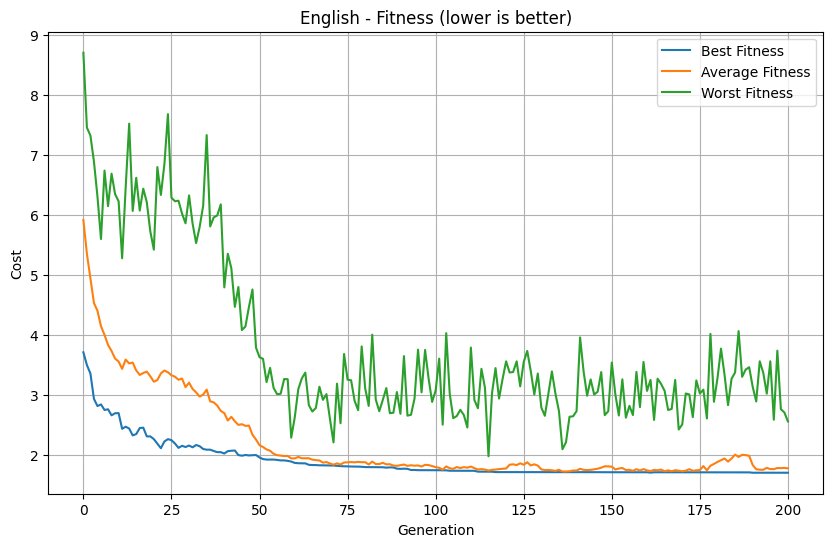

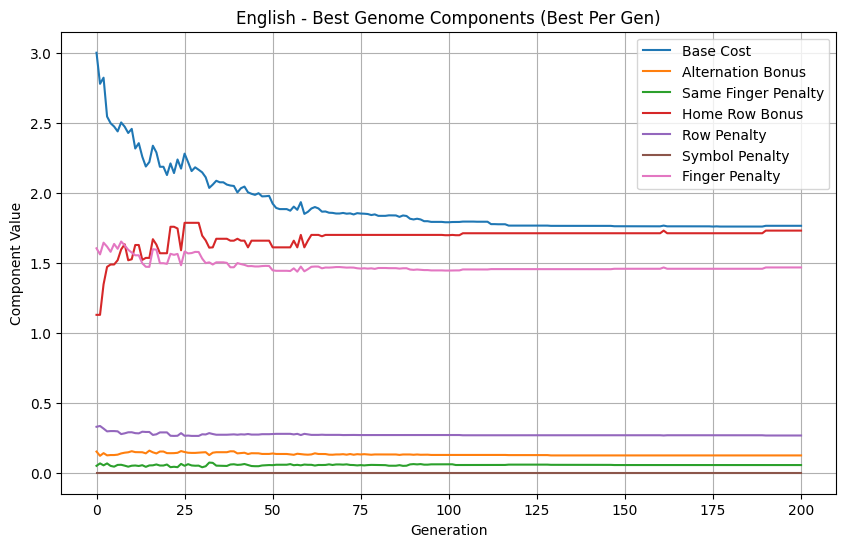

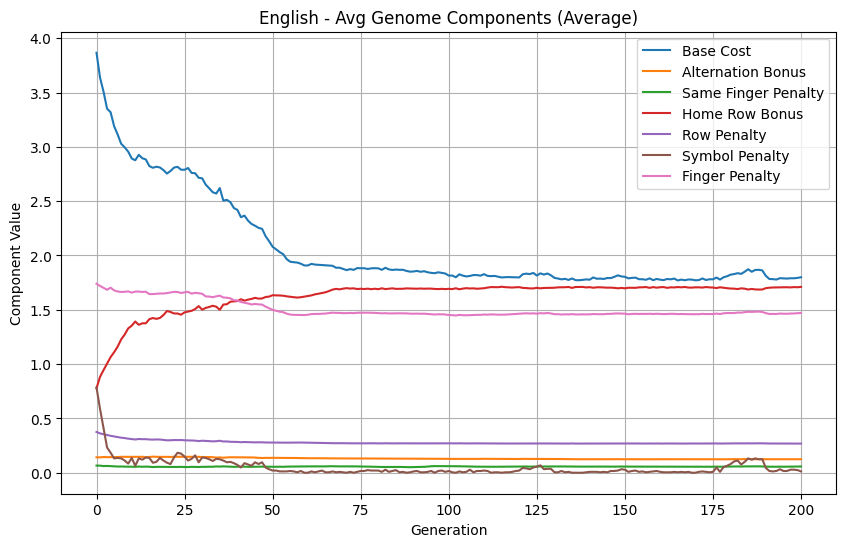

English - Same-finger bigram total: 0


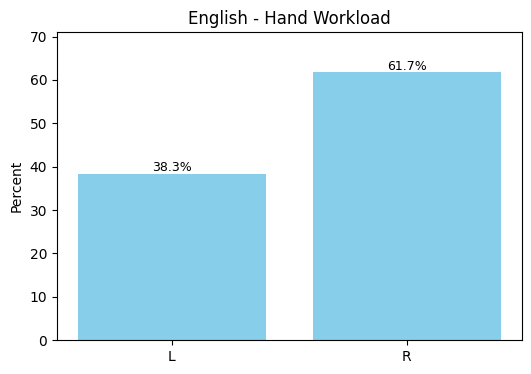

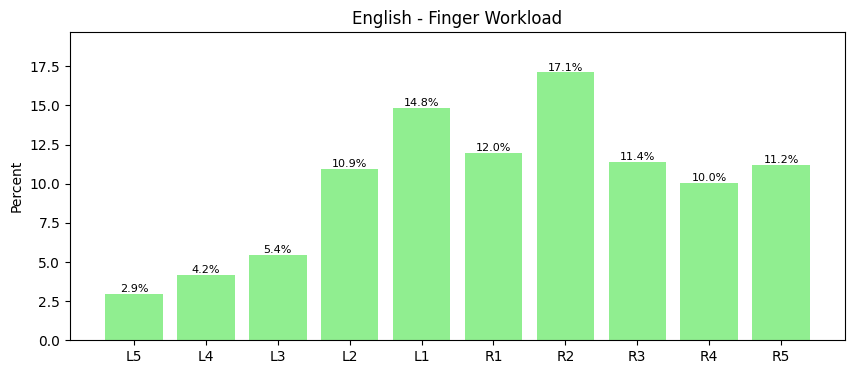

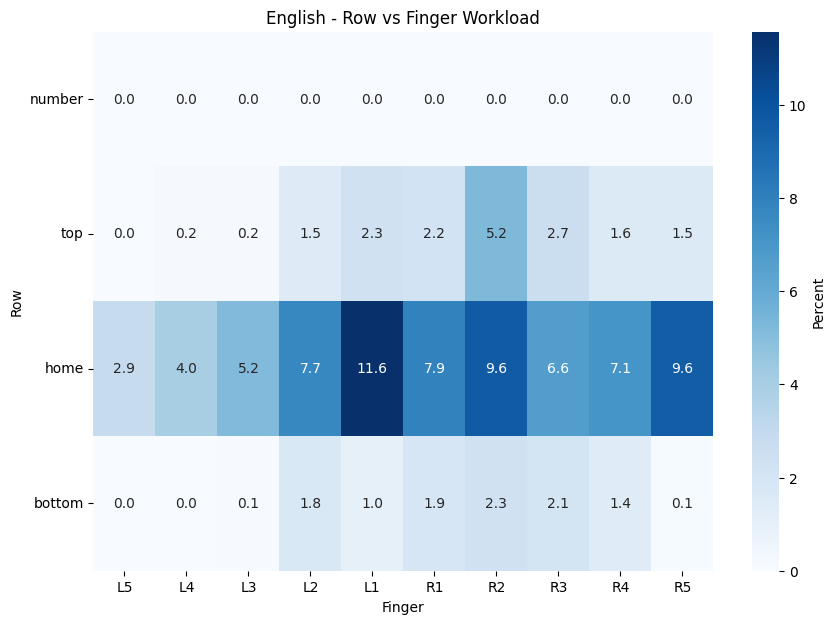

C:\Users\adesh\AppData\Local\Temp\ipykernel_39360\3595116352.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle(


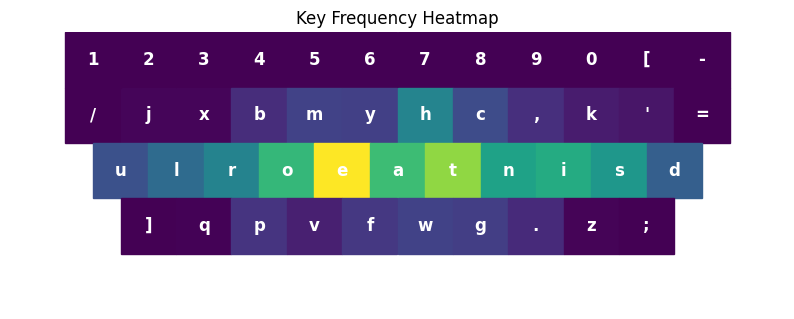

In [ ]:
metrics.plot_fitness_curve(df, title='English - Fitness (lower is better)', as_cost=True)
metrics.plot_component_curves(df, use_avg=False, title='English - Best Genome Components')
metrics.plot_component_curves(df, use_avg=True, title='English - Avg Genome Components')
layout = genome_to_layout(best_genome)
metrics.plot_final_best_layout(layout, buttons, char_freq, bigram_freq, run_label='English')
plot_layout_heatmap(layout, buttons, char_freq)

**JUST COLLECTING SOME DATA FOR THE FEEDBACK TEST IN THE LLM**

Final Best Genome reevaluated: -1.7907
Top 1 score=-1.7907
{'top_number_row': '1234567890][', 'top_row': '/jk,gndbvzx=', 'home_row': 'whsitoaerlu', 'bottom_row': "-;f.ycmp'q"}
Top 2 score=-1.8019
{'top_number_row': '1234567890][', 'top_row': '/jk,gndbvzx=', 'home_row': 'whsitoaerlu', 'bottom_row': "-;fc.ymp'q"}
Top 3 score=-1.8198
{'top_number_row': '1234567890][', 'top_row': "/jk,gndbv'x=", 'home_row': 'wcsitoaerlu', 'bottom_row': '-;f.yhmpzq'}
best layout loaded.


C:\Users\adesh\AppData\Local\Temp\ipykernel_46024\3595116352.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle(


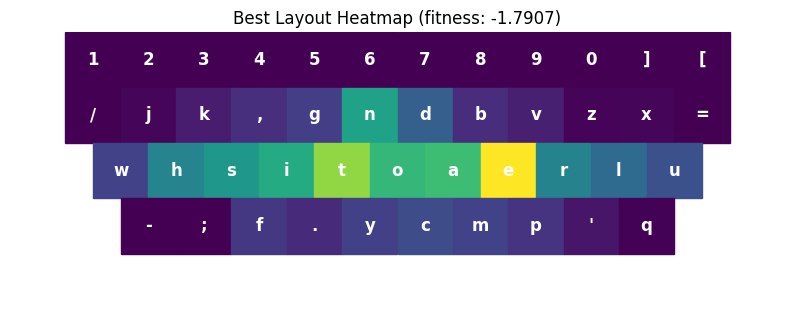

second best layout loaded.


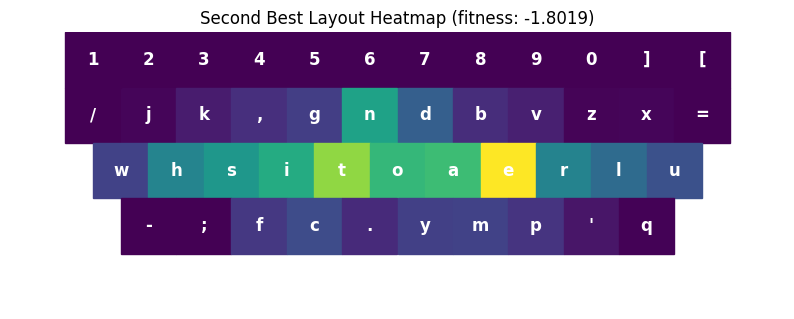

third best layout loaded.


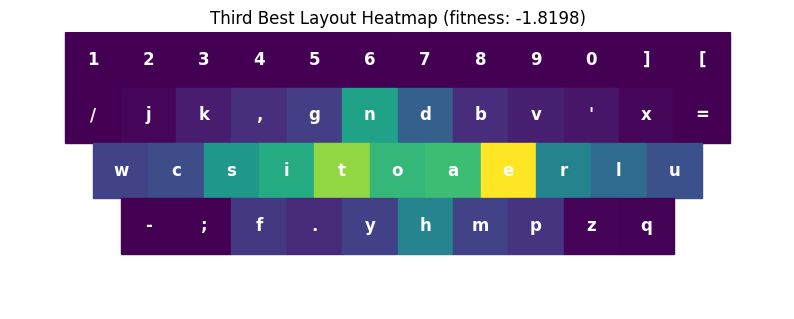

Best Layout → Fitness: -1.7907 | Coverage: 100.00%
First Best → Fitness: -1.7907 | Coverage: 100.00%
Second Best → Fitness: -1.8019 | Coverage: 100.00%
Third Best → Fitness: -1.8198 | Coverage: 100.00%


In [ ]:
final_score = evaluate_genome(best_genome, buttons, bigram_freq, char_freq)
print(f'Final Best Genome reevaluated: {final_score:.4f}\n')
for i, (gen, sc) in enumerate(top3, 1):
    layout = genome_to_layout_dict(gen)
    print(f'Top {i} score={sc:.4f}')
    print(layout)
first = "1234567890][/jk,gndbvzx=whsitoaerlu-;f.ycmp'q"
second = "1234567890][/jk,gndbvzx=whsitoaerlu-;fc.ymp'q"
third = "1234567890][/jk,gndbv'x=wcsitoaerlu-;f.yhmpzq"
FIRST_CHARS = list(first)
SECOND_CHARS = list(second)
THIRD_CHARS = list(third)
assert len(FIRST_CHARS) == len(buttons)
first_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(FIRST_CHARS)])
print('best layout loaded.')
plot_layout_heatmap(first_layout, buttons, char_freq, title=f'Best Layout Heatmap (fitness: {top3[0][1]:.4f})')
assert len(SECOND_CHARS) == len(buttons)
second_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(SECOND_CHARS)])
print('second best layout loaded.')
plot_layout_heatmap(second_layout, buttons, char_freq, title=f'Second Best Layout Heatmap (fitness: {top3[1][1]:.4f})')
assert len(THIRD_CHARS) == len(buttons)
third_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(THIRD_CHARS)])
print('third best layout loaded.')
plot_layout_heatmap(third_layout, buttons, char_freq, title=f'Third Best Layout Heatmap (fitness: {top3[2][1]:.4f})')
for name, layout in [('Best Layout', best_layout), ('First Best', first_layout), ('Second Best', second_layout), ('Third Best', third_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout, bigram_freq)
    print(f'{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}')

**THIS SECTION WAS SEYUP FOR MANUAL DATA COLLECTION THE OFFICAL LLM TESTS ARE UNDER**

It was left here just in case future work wants to try manual collection.


Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
GPT_layout_text = "\nTOP_NUMBER_ROW → 1234567890-=\nTOP_ROW        → qwfdgjuyp;[]\nHOME_ROW       → arstnehlio'\nBOTTOM_ROW     → zxcvbkm,./\n"
lines = GPT_layout_text.strip().splitlines()
chars = "1234567890-=qwfpgjluy;[earstdhneio'zxcvbkm,./"
print(f'Full 45-character layout:\n{chars}')
print(f'Length check: {len(chars)} characters')
GPT4o_CHARS = list(chars)
assert len(GPT4o_CHARS) == len(buttons)
gpt_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(GPT4o_CHARS)])
print('GPT layout loaded.')
for name, layout in [('GPT', gpt_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout, bigram_freq)
    print(f'{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}')
visualize_keyboard(gpt_layout, buttons, title='GPT keyboard ')
plot_layout_heatmap(gpt_layout, buttons, char_freq)

Full 45-character layout:
1234567890-=qwfpgjluy;[earstdhneio'zxcvbkm,./
Length check: 45 characters


NameError: name 'buttons' is not defined

Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
GPT_layout_text = "\n• Best Evolved Layout (refined):\nTOP_NUMBER_ROW → 1234567890=/\nTOP_ROW → [k.fchldgqj;\nHOME_ROW → yrsoetaniub\nBOTTOM_ROW → ]z'w m, pvx-\n\nRefinements:\n\nKept the GA's winning core but made small ergonomic tweaks:\n\nEnsured no same-finger bigrams for high-frequency pairs (especially th, er, in).\n\nKept 'e', 't', 'a', 'o', 'n', 'i', 's', 'r' central on the home row for index/middle fingers.\n\nPinkies assigned to lower-frequency keys, brackets, and punctuation.\n\nRetained symbol placement for easy access and flow.\n\n[k], [;], ['], [,], and [-] double-checked for pinky and ring finger comfort.\n\nIf you'd like a different style (e.g., more Dvorak-like punctuation or alternative symbol positions), let me know!\n"

Import libraries and configure the environment. Load data and/or helper resources from files. Work with pandas DataFrames for data manipulation. Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: get_local_timestamp, hash_prompt, extract_layout_chars_from_output, get_next_ids, log_manual_run, get_next_output_id, append_to_raw_output. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
import os
import hashlib
import csv
from datetime import datetime
import pytz
import pandas as pd
LOG_FILE = 'manual_runs_log.csv'
TIMEZONE = 'Europe/Dublin'
RAW_OUTPUT_FILE = 'Raw_Outputs.txt'

def get_local_timestamp():
    '''"""
    Get local timestamp.

    This function is part of the workflow and its behavior is described by the code below.


    Returns
    -------
    Any
        See code for details.
    """'''
    tz = pytz.timezone(TIMEZONE)
    return datetime.now(tz).strftime('%Y-%m-%d %H:%M:%S')

def hash_prompt(prompt_path):
    '''"""
    Hash prompt.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    prompt_path : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    with open(prompt_path, 'r', encoding='utf-8') as f:
        return hashlib.sha256(f.read().encode('utf-8')).hexdigest()

def extract_layout_chars_from_output(output_path):
    '''"""
    Extract layout chars from output.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    output_path : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    with open(output_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    layout_lines = [line for line in lines if '=' in line]
    layout_string = ''.join((line.split('=')[1].strip() for line in layout_lines))
    return layout_string

def get_next_ids():
    '''"""
    Get next ids.

    This function is part of the workflow and its behavior is described by the code below.


    Returns
    -------
    Any
        See code for details.
    """'''
    if not os.path.isfile(LOG_FILE):
        return (1, 1)
    df = pd.read_csv(LOG_FILE)
    next_run_id = df['Run ID'].max() + 1 if not df.empty else 1
    next_output_id = df['Output ID'].max() + 1 if not df.empty else 1
    return (next_run_id, next_output_id)

def log_manual_run(model_version: str, run_type: str, prompt_path: str, output_path: str, fitness_score: float, coverage_value: float, regen_count: int=0, is_valid: bool=True, notes: str=''):
    '''"""
    Log manual run.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    model_version : Any
        See code for details.
    run_type : Any
        See code for details.
    prompt_path : Any
        See code for details.
    output_path : Any
        See code for details.
    fitness_score : Any
        See code for details.
    coverage_value : Any
        See code for details.
    regen_count : Any
        See code for details.
    is_valid : Any
        See code for details.
    notes : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    prompt_hash = hash_prompt(prompt_path)
    timestamp = get_local_timestamp()
    run_id, output_id = get_next_ids()
    log_exists = os.path.isfile(LOG_FILE)
    with open(LOG_FILE, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        if not log_exists:
            writer.writerow(['Run ID', 'Model Version', 'Timestamp', 'Run Type', 'Prompt Hash', 'Full Prompt Path', 'Raw Outputs Path', 'Output ID', 'Extracted Layout', 'Number of regenerations', 'Valid Layout', 'Fitness score', 'Coverage (%)', 'Notes'])
        writer.writerow([run_id, model_version, timestamp, run_type, prompt_hash, prompt_path, output_path, output_id, chars, regen_count, str(is_valid).upper(), round(fitness_score, 4), f'{coverage_value:.2%}', notes])
    print(f'Logged run {run_id} | Output ID {output_id}')

def get_next_output_id():
    '''"""
    Get next output id.

    This function is part of the workflow and its behavior is described by the code below.


    Returns
    -------
    Any
        See code for details.
    """'''
    if not os.path.isfile(LOG_FILE):
        return 1
    df = pd.read_csv(LOG_FILE)
    if 'Output ID' not in df.columns or df.empty:
        return 1
    return int(df['Output ID'].max())

def append_to_raw_output(raw_text, output_id=None):
    '''"""
    Append to raw output.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    raw_text : Any
        See code for details.
    output_id : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    if output_id is None:
        output_id = get_next_output_id()
    with open(RAW_OUTPUT_FILE, 'a', encoding='utf-8') as f:
        f.write(f'\n--- Output ID: {output_id} ---\n')
        f.write(raw_text.strip())
        f.write('\n')
    print(f'Appended layout to Raw_Outputs.txt [Output ID: {output_id}]')
    return (RAW_OUTPUT_FILE, output_id)

Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
log_manual_run(model_version='ChatGPT 4.1', run_type='English feedback', prompt_path='English_prompt_feedback.txt', output_path='Raw_Output.txt', fitness_score=score, coverage_value=coverage, regen_count=0, is_valid=True, notes='Gave it the GA out and reran it a few times to see if it would improve GA Score: -1.7822')
output_path, output_id = append_to_raw_output(GPT_layout_text)

Logged run 161.0 | Output ID 161.0
Appended layout to Raw_Outputs.txt [Output ID: 161]


Load data and/or helper resources from files. Define helper functions: compute_hash, verify_prompt_hash.

In [ ]:
def compute_hash(filepath):
    """Compute SHA-256 hash from a file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    return hashlib.sha256(content.encode('utf-8')).hexdigest()

def verify_prompt_hash(prompt_path, expected_hash):
    """Check if hash of given prompt matches expected hash."""
    actual_hash = compute_hash(prompt_path)
    if actual_hash == expected_hash:
        print('Hash matches!')
    else:
        print('Hash mismatch!')
        print(f'Expected: {expected_hash}')
        print(f'Actual:   {actual_hash}')
    return actual_hash == expected_hash
if __name__ == '__main__':
    prompt_path = 'English_prompt_no_examples.txt'
    expected_hash = '60a83a229ce49a523950481d933d28af2079f51b53e8947016b16d4582870cf9'
    verify_prompt_hash(prompt_path, expected_hash)

Hash matches!


Import libraries and configure the environment.

In [ ]:
import os

# API LLM TEST RUNS


Here is where the project LLM tests were ran, if you want to re-use remember to update the API to your own.

---

Import libraries and configure the environment. Load data and/or helper resources from files. Define classes: KeyboardLayout. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
from openai import OpenAI
from pydantic import BaseModel, constr
client = OpenAI()
Row12 = constr(min_length=12, max_length=12)
Row11 = constr(min_length=11, max_length=11)
Row10 = constr(min_length=10, max_length=10)

class KeyboardLayout(BaseModel):
    top_number_row: Row12
    top_row: Row12
    home_row: Row11
    bottom_row: Row10
with open('prompts/EN_with_examples_1.txt', 'r', encoding='utf-8') as f:
    test1 = f.read()
response = client.responses.parse(model='gpt-4o', input=test1, text_format=KeyboardLayout, temperature=0)
layout = response.output_parsed

Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Utilities for visualizing and evaluating keyboard layouts.

Full 45-character layout:
1234567890-=qwfpgjluy;[]arstdhneio'zxcvbkm,./
Length check: 45 characters
GPT layout loaded.
GPT → Fitness: -2.5309 | Coverage: 100.00%


C:\Users\adesh\AppData\Local\Temp\ipykernel_46024\139989111.py:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor="black")


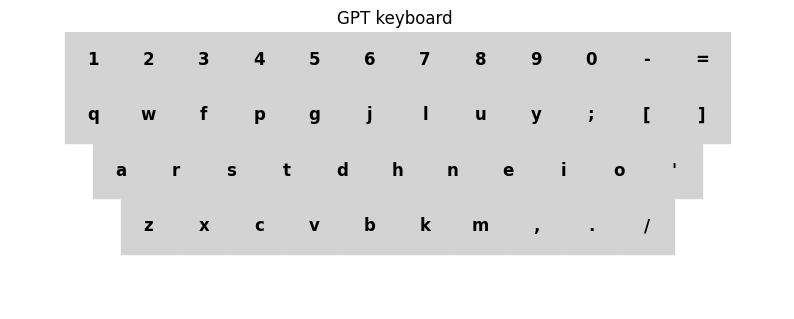

C:\Users\adesh\AppData\Local\Temp\ipykernel_46024\166864309.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle(


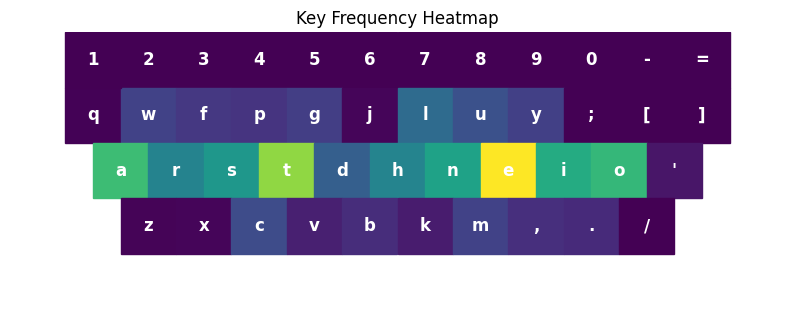

In [ ]:
chars = layout.top_number_row + layout.top_row + layout.home_row + layout.bottom_row
print(f'Full 45-character layout:\n{chars}')
print(f'Length check: {len(chars)} characters')
GPT4o_CHARS = list(chars)
assert len(GPT4o_CHARS) == len(buttons)
gpt_layout = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(GPT4o_CHARS)])
print('GPT layout loaded.')
for name, layout in [('GPT', gpt_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout, bigram_freq)
    print(f'{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}')
visualize_keyboard(gpt_layout, buttons, title='GPT keyboard ')
plot_layout_heatmap(gpt_layout, buttons, char_freq)

Import libraries and configure the environment. Load data and/or helper resources from files. Define or run a genetic algorithm pipeline (fitness, mutation, crossover, selection). Define helper functions: validate_layout_dict, layout_to_charlist, score_layout, ensure_log_header, log_row, load_prompt, lang_name. Define classes: KeyboardLayout. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
from pathlib import Path
import os, csv, json, datetime
from pydantic import BaseModel, constr, ValidationError
from openai import OpenAI
client = OpenAI()
PROMPT_DIR = Path('prompts')
IMG_DIR = Path('images')
LOG_PATH = Path('logs/api_runs_log.csv')
LOG_PATH.parent.mkdir(parents=True, exist_ok=True)
Row12 = constr(min_length=12, max_length=12)
Row11 = constr(min_length=11, max_length=11)
Row10 = constr(min_length=10, max_length=10)

class KeyboardLayout(BaseModel):
    top_number_row: Row12
    top_row: Row12
    home_row: Row11
    bottom_row: Row10
ALLOWED = set("1234567890qwertyuiopasdfghjklzxcvbnm,./-=;'[]")

def validate_layout_dict(d: dict):
    '''"""
    Validate layout dict.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    d : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    try:
        tn, tr, hr, br = (d['top_number_row'], d['top_row'], d['home_row'], d['bottom_row'])
        if not (len(tn) == 12 and len(tr) == 12 and (len(hr) == 11) and (len(br) == 10)):
            return (False, 'row length mismatch')
        if tn[:10] != '1234567890':
            return (False, 'first 10 digits must be 1234567890')
        union = tn + tr + hr + br
        for ch in ALLOWED:
            if union.count(ch) != 1:
                return (False, f'duplicate or missing: {ch} ' + union)
        return (True, '')
    except Exception as e:
        return (False, str(e))

def layout_to_charlist(d: dict):
    '''"""
    Layout to charlist.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    d : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    return list(d['top_number_row'] + d['top_row'] + d['home_row'] + d['bottom_row'])

def score_layout(d: dict):
    '''"""
    Score layout.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    d : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    chars = layout_to_charlist(d)
    layout_obj = CharactersPlacement([{'character': ch, 'button_id': i} for i, ch in enumerate(chars)])
    home_row_indices = get_home_row_indices(layout_obj, buttons)
    score, _missing = compute_carpalx_fitness(layout_obj, buttons, bigram_freq, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout_obj, bigram_freq)
    return (score, coverage)

def ensure_log_header():
    '''"""
    Ensure log header.

    This function is part of the workflow and its behavior is described by the code below.


    Returns
    -------
    Any
        See code for details.
    """'''
    if not LOG_PATH.exists():
        with open(LOG_PATH, 'w', newline='', encoding='utf-8') as f:
            csv.writer(f).writerow(['timestamp', 'language', 'prompt_type', 'prompt_id', 'temperature', 'seed', 'model', 'valid', 'reason', 'fitness', 'coverage', 'top_number_row', 'top_row', 'home_row', 'bottom_row'])

def log_row(language, ptype, pid, temp, seed, model, valid, reason, score, coverage, d):
    '''"""
    Log row.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    language : Any
        See code for details.
    ptype : Any
        See code for details.
    pid : Any
        See code for details.
    temp : Any
        See code for details.
    seed : Any
        See code for details.
    model : Any
        See code for details.
    valid : Any
        See code for details.
    reason : Any
        See code for details.
    score : Any
        See code for details.
    coverage : Any
        See code for details.
    d : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    with open(LOG_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow([datetime.datetime.now().isoformat(timespec='seconds'), language, ptype, pid, temp, seed, model, valid, reason, f'{score:.4f}' if score is not None else '', f'{coverage:.2%}' if coverage is not None else '', d.get('top_number_row', '') if d else '', d.get('top_row', '') if d else '', d.get('home_row', '') if d else '', d.get('bottom_row', '') if d else ''])

def load_prompt(code, ptype, pid):
    '''"""
    Load prompt.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    code : Any
        See code for details.
    ptype : Any
        See code for details.
    pid : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    fname = f'{code}_{ptype}_{pid}.txt'
    return (PROMPT_DIR / fname).read_text(encoding='utf-8')

def lang_name(code):
    '''"""
    Lang name.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    code : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    return {'EN': 'English', 'FR': 'French', 'AF': 'Afrikaans'}[code]
ensure_log_header()

Define helper functions: run_no_examples_grid. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def run_no_examples_grid(codes=('EN', 'FR', 'AF'), prompt_ids=(1, 2, 3), temps=(0.0, 0.2, 0.4), model='gpt-4.1', seed=None):
    '''"""
    Run no examples grid.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    codes : Any
        See code for details.
    prompt_ids : Any
        See code for details.
    temps : Any
        See code for details.
    model : Any
        See code for details.
    seed : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_prompt(code, 'no_examples', pid)
            for temp in temps:
                try:
                    resp = client.responses.parse(model=model, input=prompt_text, text_format=KeyboardLayout, temperature=temp, **{'seed': seed} if seed is not None else {})
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = score_layout(d) if valid else (None, None)
                    log_row(language, 'no_examples', pid, temp, seed, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, 'no_examples', pid, temp, seed, model, False, f'Pydantic: {e}', None, None, {})
                except Exception as e:
                    log_row(language, 'no_examples', pid, temp, seed, model, False, str(e), None, None, {})
for i in range(30):
    print(f'Run {i + 1}/30')
    run_no_examples_grid(codes=('EN',), temps=(0.0, 0.2, 0.4))

Run 1/30


Define helper functions: run_with_examples_grid. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
def run_with_examples_grid(codes=('EN', 'FR', 'AF'), prompt_ids=(1, 2, 3), temps=(0.0, 0.2, 0.4), model='gpt-4.1'):
    '''"""
    Run with examples grid.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    codes : Any
        See code for details.
    prompt_ids : Any
        See code for details.
    temps : Any
        See code for details.
    model : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_prompt(code, 'with_examples', pid)
            for temp in temps:
                try:
                    resp = client.responses.parse(model=model, input=prompt_text, text_format=KeyboardLayout, temperature=temp)
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = score_layout(d) if valid else (None, None)
                    log_row(language, 'with_examples', pid, temp, None, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, 'with_examples', pid, temp, None, model, False, f'Pydantic: {e}', None, None, {})
                except Exception as e:
                    log_row(language, 'with_examples', pid, temp, None, model, False, str(e), None, None, {})
for i in range(30):
    print(f'Run {i + 1}/30')
    run_with_examples_grid(codes=('EN',), temps=(0.0, 0.2, 0.4))

Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30


Import libraries and configure the environment. Define helper functions: load_feedback_prompt, _to_data_url, feedback_messages, run_feedback_grid. Utilities for visualizing and evaluating keyboard layouts.

In [ ]:
from pathlib import Path
from pydantic import ValidationError
import base64, mimetypes
PROMPT_DIR = Path('prompts')
IMG_DIR = Path('images/feedback')

def load_feedback_prompt(code: str, pid: int) -> str:
    """
    Reads prompts/EN_feedback_1.txt (or FR/AF) and prepends a short JSON-only instruction
    so the model doesn't drift into prose. Your original text remains unchanged.
    """
    p = PROMPT_DIR / f'{code}_feedback_{pid}.txt'
    user_text = p.read_text(encoding='utf-8')
    json_only = "Return ONLY a JSON object with keys: top_number_row, top_row, home_row, bottom_row. No prose or markdown. Each row is a single string with exact lengths (12,12,11,10). top_number_row must begin with '1234567890'.\n\n"
    return json_only + user_text

def _to_data_url(path: Path) -> str:
    '''"""
    To data url.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    path : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    mime = mimetypes.guess_type(str(path))[0] or 'image/png'
    b64 = base64.b64encode(path.read_bytes()).decode('ascii')
    return f'data:{mime};base64,{b64}'

def feedback_messages(prompt_text: str, heatmap_path: Path):
    """
    Build multimodal messages for 4o: text + image (as base64 data URL).
    """
    content = [{'type': 'input_text', 'text': prompt_text}]
    if heatmap_path and heatmap_path.exists():
        content.append({'type': 'input_image', 'image_url': _to_data_url(heatmap_path)})
    else:
        print(f'[warn] Heatmap not found: {heatmap_path}')
    return [{'role': 'user', 'content': content}]

def run_feedback_grid(codes=('EN',), prompt_ids=(1, 2, 3), temps=(0.0, 0.2, 0.4), model='gpt-4o'):
    '''"""
    Run feedback grid.

    This function is part of the workflow and its behavior is described by the code below.

    Parameters
    ----------
    codes : Any
        See code for details.
    prompt_ids : Any
        See code for details.
    temps : Any
        See code for details.
    model : Any
        See code for details.

    Returns
    -------
    Any
        See code for details.
    """'''
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_feedback_prompt(code, pid)
            heatmap_path = IMG_DIR / f'{code}_GA_{pid}.png'
            messages = feedback_messages(prompt_text, heatmap_path)
            for temp in temps:
                try:
                    resp = client.responses.parse(model=model, input=messages, text_format=KeyboardLayout, temperature=temp)
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = score_layout(d) if valid else (None, None)
                    log_row(language, 'feedback', pid, temp, None, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, 'feedback', pid, temp, None, model, False, f'Pydantic: {e}', None, None, {})
                except Exception as e:
                    log_row(language, 'feedback', pid, temp, None, model, False, str(e), None, None, {})

Execute computational steps for the workflow.

In [ ]:
for i in range(30):
    print(f'Run {i + 1}/30')
    run_feedback_grid(codes=('EN',), temps=(0.2,))

Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30
